# EXPONENTIAL MODEL CATALOGE - Selected sessions for monkey Popey

Monkey PO started to ignore target-2 after a couple of sessions. The goal here to fit only on those sessions when he cooperated and used all the targets as it assumed. 

In [30]:
import warnings
warnings.filterwarnings("ignore")

In [31]:
import pickle
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import metrics
import scipy as sp
from scipy.special import softmax
from scipy.optimize import minimize
from bandits_helper_functions import*
from exponential_model import*
from paths import*
import pickle as pkl
import datetime
from openpyxl import load_workbook

## Define paths, import data

In [32]:
paths = Paths()
fig_save_path = paths.fig_save_path + 'exponential_model/'
data = pd.read_excel(paths.data + 'behavioural_data.xlsx', index_col=[0], converters={'session': str})

In [33]:
data = pd.read_excel(paths.data + 'behavioural_data.xlsx', index_col=[0], converters={'session': str})
data["date"] = pd.to_datetime(data["session"], format = "%d%m%y")
data["date"] =  data['date'].dt.date

## Data formatting
- Drop the trials where the monkey didn't make any choice
- Keep only a smaller subset with the relevant columns

In [34]:
data = data.loc[~data['feedback'].isnull()]
data_subset = data[['monkey', 'session', 'date', 'trial_id', 'block_id', 'best_target', 'target', 'feedback']]

## Split the data according to the subject

In [35]:
po_data = data_subset.loc[data_subset['monkey'] == 'po']

In [36]:
po_data = get_shift_stay_variables(po_data)

## Assign alternative feedback coding columns

In [37]:
po_data.loc[po_data["feedback"] == 0, 'feedback_11'] = -1
po_data.loc[po_data["feedback"] == 1, 'feedback_11'] = 1
#po_data[['feedback', 'feedback_11']]

#### Get the previous traials' feedback history & Calculate choice match weight (CMW)

In [38]:
po_data_fb_01_cmw_11 = get_n_back(po_data, reward_code='feedback')

In [39]:
po_data_fb_01_cmw_11 = get_binary_choice_match_value(po_data_fb_01_cmw_11, coding = '-11')

----

In [40]:
last_cooperative_day =  datetime.datetime.strptime('2021-04-9', "%Y-%m-%d").date()
po_cooperative_data =  po_data_fb_01_cmw_11.loc[po_data_fb_01_cmw_11['date'] <= last_cooperative_day]
po_non_cooperative_data =  po_data_fb_01_cmw_11.loc[po_data_fb_01_cmw_11['date'] > last_cooperative_day]

In [41]:
#po_cooperative_data

## Feedback Source Sensitive (FSS)  model with reward coding {0, 1}

### PO_FSS_01

In [72]:
PO_FSS_01 = Optimize_exponent()
PO_FSS_01.optimise_model(data = po_data_fb_01_cmw_11, name = 'PO_FSS_01',
                         FSS = True, fit_a2 = False, fit_eps = False, 
                         bounds = ((None, None), (0, 0), (-3, 1), (None, None), (0, 0)))

print_model_params(PO_FSS_01)
#save_model_results(PO_FSS_01)
#PO_FSS_01.save_data()

###################
Model name: PO_FSS_01
###################
Fitted params: {'a': 1279.1980338738779, 'a2': None, 'b': -0.7949927334589239, 'c': -31.297389849681117, 'eps': None}
reward coding: {0.0, 1.0}
cmw coding: {1.0, -1.0}
###################
Log loss: 0.19622
###################


## FSS 01 model for the cooperative phase

### PO_FSS_01_coop

In [43]:
PO_FSS_01_coop = Optimize_exponent()
PO_FSS_01_coop.optimise_model(data = po_cooperative_data, name = 'PO_FSS_01_coop',
                         FSS = True, fit_a2 = False, fit_eps = False, 
                         bounds = ((None, None), (0, 0), (-3, 1), (None, None), (0, 0)))

In [44]:
print_model_params(PO_FSS_01_coop)
#save_model_results(PO_FSS_01)
#PO_FSS_01_coop.save_data()

###################
Model name: PO_FSS_01_coop
###################
Fitted params: {'a': 1347.6741488007376, 'a2': None, 'b': -0.8666856187676758, 'c': -45.41943078104467, 'eps': None}
reward coding: {0.0, 1.0}
cmw coding: {1.0, -1.0}
###################
Log loss: 0.21309
###################


### PO_FSS_01_non_coop

In [45]:
###Whats going on here? 

PO_FSS_01_non_coop = Optimize_exponent()
PO_FSS_01_non_coop.optimise_model(data = po_non_cooperative_data, name = 'PO_FSS_01_non_coop',
                         FSS = True, fit_a2 = False, fit_eps = False, 
                         bounds = ((0, 1), (0, 0), (-1, 1), (-0.1, 0.1), (0, 0)))

In [46]:
print_model_params(PO_FSS_01_non_coop)
#save_model_results(PO_FSS_01)
#PO_FSS_01_coop.save_data()

###################
Model name: PO_FSS_01_non_coop
###################
Fitted params: {'a': 1.0, 'a2': None, 'b': 0.5837815993934555, 'c': 0.1, 'eps': None}
reward coding: {0.0, 1.0}
cmw coding: {1.0, -1.0}
###################
Log loss: 0.50867
###################


## Analyse the cooperative fitted model

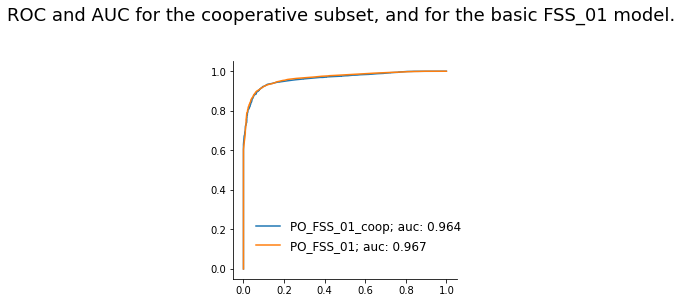

In [49]:
data_files = ['PO_FSS_01_coop.csv', 'PO_FSS_01.csv']

fig, ax = plt.subplots(1,1, figsize = (4, 4), facecolor = 'white')


i = 0
for f in data_files:  
    data = pd.read_csv(paths.model_outputs + f)
    auc = metrics.roc_auc_score(data.stay, data.exponent_model)
    fpr, tpr, _ = metrics.roc_curve(data.stay, data.exponent_model)
    label = f[:-4] + '; auc: ' + str(np.round(auc, 4))
    ax.plot(fpr, tpr, label= label)
    ax.legend(frameon = False, fontsize = 12, loc =(0.08, 0.1));
    i += 1
    
# ax[0].set_title('KA', fontsize = 16)
# ax[1].set_title('PO', fontsize = 16)


sns.despine()
plt.subplots_adjust(wspace = 1)
plt.suptitle('ROC and AUC for the cooperative subset, and for the basic FSS_01 model.', fontsize = 18, y = 1.07);

plt.savefig(fig_save_path + 'PO_cooperative_phase_vs_all_phase.png', dpi = 300, bbox_inches='tight');